# Point Cloud Based 3D Object Detection Inference using ONNX Runtime


## Inference using Pre-Compiled Models
In this example notebook, we describe how to use a pre-trained Point Cloud Based 3D Object Detection model for inference using the ***ONNX Runtime interface***.
   - Model is based on point pillars [Link](https://arxiv.org/abs/1812.05784) method.
   - Model is trained for only one class, which is 'car'
   - We perform inference on a few sample point clouds
   - We also describe the input preprocessing and output postprocessing steps, demonstrate how to collect various benchmarking statistics and how to visualize the data.


## Point Cloud Based 3D Object Detection  

3D Object Detection is a popular computer vision algorithm used in many applications such as Person Detection and Vehicle detection. 3D object information provides better understanding surrounding and hence helps in precise path planning. 3D object detection on lidar data outperforms than image data. 

## ONNX Runtime based Work flow

The diagram below describes the steps for ONNX Runtime based workflow. 

Note:
- The user needs to compile models(sub-graph creation and quantization) on a PC to generate model artifacts.
    - For this notebook we use pre-compiled models artifacts
- The generated artifacts can then be used to run inference on the target.
- Users can run this notebook as-is, only action required is to select a model. 

<img src=docs/images/onnx_work_flow_2.png width="400">

In [1]:
import os
import cv2
import numpy as np
import ipywidgets as widgets
from scripts.utils import get_eval_configs

prebuilt_configs, selected_model_id = get_eval_configs('lidar-3d-detection','onnxrt', num_quant_bits = 8, last_artifacts_id = None)

lidar-3d-detection
onnxrt
{'lidar-3dod-7100': {'task_type': 'lidar-3d-detection', 'calibration_dataset': None, 'input_dataset': None, 'postprocess': None, 'preprocess': None, 'session': <jai_benchmark.sessions.onnxrt_session.ONNXRTSession object at 0x7f246ac9dd30>, 'metric': {'label_offset_pred': None}, 'model_info': {'metric_reference': {'accuracy_ap[.5:.95]%': 47.1}}}}
[('ONR-LIDAR-3DOD-7100-pointPillars_20000', 'lidar-3dod-7100')]


In [2]:
print(f'Selected Model: {selected_model_id.label}')
config = prebuilt_configs[selected_model_id.value]
config['session'].set_param('model_id', selected_model_id.value)
config['session'].start()

Selected Model: ONR-LIDAR-3DOD-7100-pointPillars_20000
INFO:20211214-114902: model_path - /home/a0393749/deepak_files/bitbucket/edgeai-tidl-tools/examples/edgeai-modelzoo/models/lidar/detection/kitti/pointPillars/point-pillars-combined_model_simple_mod.onnx
INFO:20211214-114902: model_file - /home/a0393749/deepak_files/bitbucket/edgeai-tidl-tools/examples/jupyter_notebooks/prebuilt-models/8bits/lidar-3dod-7100_onnxrt_pointPillars_point-pillars-combined_model_simple_mod_onnx/model/point-pillars-combined_model_simple_mod.onnx


## Define utility function to preprocess input point cloud

Input point cloud is segregated in 3D bins called as voxels.Features are computed for each voxels. Steps involved in pre-processing are

 1. Initialize the voxel property such as min_x, max_x.... voxel_size_x, voxel_size_y etc.
 2. Initialize the network related limitations such as max_points_per_voxel, nw_max_num_voxels, num_feat_per_voxel.
 3. Point clouds are which are outside the interested range are discarded
 4. Point cloud is segregated in voxels
 5. Features are computed for each voxel as per the model requirement.
 
 step #1 and #2 happens in below cell
 step #3 to #5 happens as part of preprocessing API 'voxelization'

In [3]:
voxelization_config_params={}

# voxel property 
voxelization_config_params['min_x'] = 0
voxelization_config_params['max_x'] = 69.120
voxelization_config_params['min_y'] = -39.680
voxelization_config_params['max_y'] = 39.680
voxelization_config_params['min_z'] = -3.0
voxelization_config_params['max_z'] = 1.0
voxelization_config_params['voxel_size_x']= 0.16
voxelization_config_params['voxel_size_y']= 0.16
voxelization_config_params['num_voxel_x'] = (voxelization_config_params['max_x'] - voxelization_config_params['min_x'])/voxelization_config_params['voxel_size_x']
voxelization_config_params['num_voxel_y'] = (voxelization_config_params['max_y'] - voxelization_config_params['min_y'])/voxelization_config_params['voxel_size_y']

# As per below network property
voxelization_config_params['max_points_per_voxel'] = 32
voxelization_config_params['nw_max_num_voxels']  = 20000
voxelization_config_params['num_feat_per_voxel'] = 9


In [4]:
import onnxruntime as rt

onnx_model_path = config['session'].get_param('model_file')
delegate_options = {}
so = rt.SessionOptions()
delegate_options['artifacts_folder'] = config['session'].get_param('artifacts_folder')

EP_list = ['TIDLExecutionProvider','CPUExecutionProvider']
sess = rt.InferenceSession(onnx_model_path ,providers=EP_list, provider_options=[delegate_options, {}], sess_options=so)

input_details = sess.get_inputs()
output_details = sess.get_outputs()

## Create the model using the stored artifacts
<div class="alert alert-block alert-warning">
<b>Warning:</b> It is recommended to use the ONNX Runtime APIs in the cells below without any modifications.
</div>

## Perform inference

### Preprocessing and Inference
  - We perform inference on a set of lidar data from the `/sample-lidar` directory. 
  - We use a loop to preprocess the selected lidar point cloud, and provide them as the input to the network.

### Postprocessing and Visualization
 - Once the inference results are available, we postpocess the results and visualize the inferred classes for each of the input lidar data.
 - Object Detection models return results as a list (i.e. `numpy.ndarray`) with length of 9. Each element in this list contains, the detected object class ID, the probability of the detection and the bounding box co-ordinates.
 - We use the `boxes3d_to_corners3d_lidar()` function to draw detected 3D boxes on the each object with unique colors for each class ID.
 - Then, in this notebook, we use *matplotlib* to plot the original images and the corresponding results.

In [5]:
image_files = [
    ('sample-images/000008.png', 221),
    ('sample-images/000008.png', 222),
]

lidar_files =[
    ('sample-lidar/000008.bin'),
    ('sample-lidar/000008.bin'),
]

100%|██████████| 2/2 [00:56<00:00, 28.40s/it]


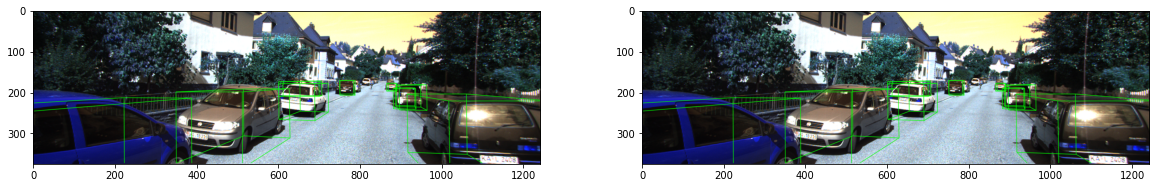

In [6]:
import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from scripts.utils_lidar import boxes3d_to_corners3d_lidar
from scripts.utils_lidar import draw_lidar_bbox3d_on_img
from scripts.utils_lidar import voxelization

plt.figure(figsize=(20,10))

# use results from the past inferences
input0 = np.zeros((1, 9, 32, 20000),dtype='float32')
input1 = np.zeros((1, 64, 214272),dtype='float32')
input2 = np.zeros((1, 64, 20000),dtype='int32')
lidar2img_rt = np.loadtxt('sample-lidar/lidar_to_image.txt')

for num in tqdm.trange(len(image_files)):
    image_file, grid = image_files[num]
    lidar_file       = lidar_files[num]

    img  = cv2.imread(image_file)
    ax   = plt.subplot(grid)

    lidar_data = np.fromfile(lidar_file, dtype='float32')
    lidar_data = np.reshape(lidar_data,(-1,4))
    voxelization(lidar_data,voxelization_config_params,input0[0],input2[0][0])
    # indices are same for all 64 channels, hence replciating them
    input2[0][1:64] = input2[0][0]

    output = sess.run(None, {input_details[0].name: input0, input_details[1].name: input2, input_details[2].name: input1})
    selected_objs = output[0][0][0][(output[0][0][0][:,1]>0.5)]
    corners = boxes3d_to_corners3d_lidar(selected_objs[:,2:])
    img = draw_lidar_bbox3d_on_img(corners,img,lidar2img_rt)

    ax.imshow(img)

plt.show()


## Plot Inference benchmarking statistics
 - During model execution several benchmarking statistics such as timestamps at different checkpoints, DDR bandwidth are collected and stored. 
 - The `get_TI_benchmark_data()` function can be used to collect these statistics. The statistics are collected as a dictionary of `annotations` and corresponding markers.
 - We provide the utility function plot_TI_benchmark_data to visualize these benchmark KPIs.

<div class="alert alert-block alert-info">
<b>Note:</b> The values represented by <i>Inferences Per Second</i> and <i>Inference Time Per Image</i> uses the total time taken by the inference except the time taken for copying inputs and outputs. In a performance oriented system, these operations can be bypassed by writing the data directly into shared memory and performing on-the-fly input / output normalization.
</div>


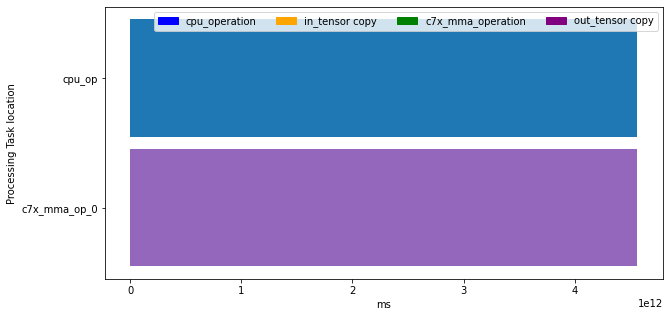

SoC: J721E/DRA829/TDA4VM
 OPP:
  Cortex-A72 @2GHZ
  DSP C7x-MMA @1GHZ
  DDR @4266 MT/s

ONR-OD-8000-ssd1200-resNet34-mlperf-1200x1200 :
 Inferences Per Second    :   -0.00 fps
 Inference Time Per Image : -4565474650155.54 ms
 DDR usage Per Image      :    0.00 MB


In [9]:
from scripts.utils import plot_TI_performance_data, plot_TI_DDRBW_data, get_benchmark_output
stats = sess.get_TI_benchmark_data()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
plot_TI_performance_data(stats, axis=ax)
plt.show()

tt, st, rb, wb = get_benchmark_output(stats)

print(f'SoC: J721E/DRA829/TDA4VM')
print(f' OPP:')
print(f'  Cortex-A72 @2GHZ')
print(f'  DSP C7x-MMA @1GHZ')
print(f'  DDR @4266 MT/s\n')
print(f'{selected_model_id.label} :')
print(f' Inferences Per Second    : {1000.0/tt :7.2f} fps')
print(f' Inference Time Per Image : {tt :7.2f} ms')
print(f' DDR usage Per Image      : {rb+ wb : 7.2f} MB')